# Recommendation System

Recommendation systems are a crucial application of machine learning that aim to provide personalized suggestions to users for products, services, or content they might be interested in. These systems have become an integral part of various online platforms, including e-commerce websites, streaming services, social media platforms, and more. The primary goal of recommendation systems is to enhance user experience by delivering relevant and personalized recommendations, which can lead to increased user engagement, satisfaction, and ultimately, higher conversion rates for businesses.

## Types of Recommendation Systems:
* Content-Based Recommendation
* Collaborative Filtering
* Hybrid Recommendation

## Importance of Recommendation Systems:
* Personalization
* Enhanced User Experience
* Increased Revenue and Conversion
* Retention and Loyalty
* Data-Driven Insights
* Competitive Advantage
* Cross-Selling and Upselling

In this notebook, I will train a recommendation system using Collaborative filtering and Deep Learning. 

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
## Read in the datasets
movies = pd.read_csv('/kaggle/input/movie-recommendation-system/movies.csv')
ratings = pd.read_csv('/kaggle/input/movie-recommendation-system/ratings.csv',low_memory=False)

In [3]:
print(movies.shape)
print(ratings.shape)

(62423, 3)
(25000095, 4)


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [6]:
data = pd.merge(movies,ratings,on='movieId')
data.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,890492517


In [7]:
n_users = len(ratings['userId'].unique())
n_movies = len(movies['title'].unique())
n_factors = 10 # Can use any value we like

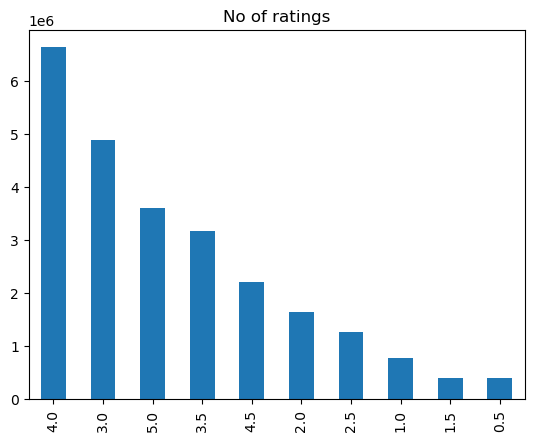

In [8]:
data['rating'].value_counts().plot(kind='bar',title='No of ratings')
plt.show()

## Metric

The following code defines a function called compute_map that calculates the mean average precision (MAP) for a list of ground-truth ratings and predicted scores. MAP is a metric commonly used in information retrieval and recommendation systems to evaluate the performance of ranking algorithms.

In [9]:
def compute_map(y_true, y_score, k=None):
    """
    Compute mean average precision (MAP) given a list of ground-truth ratings and predicted scores.

    Args:
        y_true (list): List of ground-truth ratings, where each element is either 0 (negative) or 1 (positive).
        y_score (list): List of predicted scores, where each element is a real number between 0 and 1.
        k (int, optional): The maximum number of items to consider. If None, consider all items. Defaults to None.

    Returns:
        float: The mean average precision (MAP) score.
    """
    if k is not None:
        y_true = y_true[:k]
        y_score = y_score[:k]

    # Sort the items by score in descending order
    sorted_indices = sorted(range(len(y_score)), key=lambda i: y_score[i], reverse=True)
    y_true_sorted = [y_true[i] for i in sorted_indices]

    # Compute the average precision at each position
    ap = 0.0
    tp = 0.0
    fp = 0.0
    for i, label in enumerate(y_true_sorted):
        if label == 1:
            tp += 1.0
        else:
            fp += 1.0
        ap += tp / (tp + fp) * label

    # Compute the mean average precision
    if sum(y_true) > 0:
        map_score = ap / sum(y_true)
    else:
        map_score = 0.0

    return map_score


This function is useful for evaluating the performance of recommendation systems by comparing the predicted item rankings to the ground-truth rankings. **A higher MAP score indicates better ranking performance**, suggesting that the recommendation system is more effectively providing relevant items to users.

In [10]:
class RecSys(nn.Module):
    def __init__(self,n_users,n_movies,embedding_size):
        super(RecSys,self).__init__()
        self.user_embedding = nn.Embedding(n_users,embedding_size)
        self.movie_embedding = nn.Embedding(n_movies,embedding_size)
        self.user_bias = nn.Embedding(n_users,1)
        self.movie_bias = nn.Embedding(n_movies,1)
        self.fc1 = nn.Linear(embedding_size*2,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self,user_ids,movie_ids):
        user_embedded = self.user_embedding(user_ids)
        movie_embedded = self.movie_embedding(movie_ids)
        user_bias = self.user_bias(user_ids)
        movie_bias = self.movie_bias(movie_ids)
        x = torch.cat([user_embedded,movie_embedded],dim=1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = x + user_bias + movie_bias
        return x

In [11]:
# Convert user and item IDs to integers
user_ids = {id: i for i, id in enumerate(data['userId'].unique())}
movie_ids = {id: i for i, id in enumerate(data['movieId'].unique())}
data['userId'] = data['userId'].apply(lambda x: user_ids[x])
data['movieId'] = data['movieId'].apply(lambda x: movie_ids[x])

# Split the data into training and test sets
train_data = data.sample(frac=0.8, random_state=123)
test_data = data.drop(train_data.index)

# Define a PyTorch Dataset for the training and test sets
class RatingDataset(Dataset):
    def __init__(self, data):
        self.user_ids = data['userId'].values
        self.movie_ids = data['movieId'].values
        self.ratings = data['rating'].values
        
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, idx):
        user_id = self.user_ids[idx]
        movie_id = self.movie_ids[idx]
        rating = self.ratings[idx]
        return user_id, movie_id, rating

train_dataset = RatingDataset(train_data)
test_dataset = RatingDataset(test_data)

# Define PyTorch DataLoaders for the training and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Initialize model and optimizer
model = RecSys(n_users,n_movies,n_factors)
optimizer = optim.AdamW(model.parameters(),lr=0.0015)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

def train(train_loader,optimizer,num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for user_id, movie_id, rating in train_loader:
            user_id = user_id.to(device) ## Move to GPU for faster processing
            movie_id = movie_id.to(device)
            optimizer.zero_grad()  # Set gradients to zero
            outputs = model(user_id, movie_id)
            loss = compute_map(rating, outputs)
            loss = torch.tensor(loss, requires_grad=True)  # Wrap in Variable with requires_grad=True
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1} MAP: {running_loss/len(train_loader)}")
        
def evaluate(test_loader, model):
    model.eval()  # Set the model to evaluation mode

    running_loss = 0.0
    num_samples = 0

    for user_id, movie_id, rating in test_loader:
        with torch.no_grad():  # Disable gradient computation during evaluation
            outputs = model(user_id, movie_id)
            loss = compute_map(rating, outputs)
            running_loss += loss.item()
            num_samples += 1

    map_score = running_loss / num_samples
    return map_score


The parameters of the model will still be updated even if the loss value does not require gradients. This is because the optimizer updates the parameters based on the gradients of the loss function with respect to the parameters, not the gradients of the loss value itself.

When you call loss.backward(), the gradients of the loss function with respect to the parameters are computed using the chain rule of differentiation. These gradients are then used by the optimizer to update the parameters of the model during the optimizer.step() call.

So even if the loss value itself does not require gradients, as long as the gradients of the loss function with respect to the parameters are computed and used to update the parameters, the model will still learn from the training data and improve its predictions over time.

In [ ]:
train(train_loader,optimizer,num_epochs=3)
print(evaluate(test_loader, model))

/tmp/ipykernel_28/1486816513.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.tensor(loss, requires_grad=True)  # Wrap in Variable with requires_grad=True


Epoch 1 MAP: 0.030020420998686837
Epoch 2 MAP: 0.030015520503757675
Epoch 3 MAP: 0.03002057286854957


In [ ]:
import csv

# Create a dictionary mapping movie IDs to their titles
movie_id_to_title = {}
with open('/kaggle/input/movie-recommendation-system/movies.csv', 'r', encoding='utf8') as f:
    reader = csv.reader(f)
    next(reader)  # Skip header row
    for row in reader:
        movie_id = int(row[0])
        title = row[1]
        movie_id_to_title[movie_id] = title

In [ ]:
def recommend_movies(model, user_id, top_n=10):
    # Get the movie IDs for all movies
    movie_ids = torch.arange(n_movies)

    # Repeat the user ID for all movies
    user_ids = torch.full((n_movies,), user_id)

    # Get the predicted ratings for all movies by the given user
    ratings = model(user_ids, movie_ids)

    # Sort the movie IDs by predicted rating in descending order
    sorted_indices = torch.argsort(ratings, descending=True)

    # Get the top N movie IDs
    top_indices = sorted_indices[:top_n]

    # Convert the indices to movie IDs
    top_movie_ids = [int(movie_ids[i]) for i in top_indices]

    # Get the movie titles for the top N movie IDs
    top_movie_titles = []
    for movie_id in top_movie_ids:
        if movie_id in movie_id_to_title:
            top_movie_titles.append(movie_id_to_title[movie_id])
        else:
            top_movie_titles.append(f"Movie Id:{movie_id}")

    return top_movie_titles

recommend_movies(model, user_id=12, top_n=10) ## Not best of function to retrieve recommendations
## It is better to retrieve recommendation from the embedding created by the model